# Introduction to Python and Natural Language Technologies

__Lecture 12, Decorators, Packaging, Type hints__

__May 4, 2021__

__Judit Ács__

# Decorators

## Introduction

Let's define a function that
- takes another function as a parameter
- greets the caller before calling the function

In [1]:
def greeter(func):
    print("Hello")
    func()
    
def say_something():
    print("Let's learn some Python.")
    
greeter(say_something)
# greeter(12)  # raises TypeError

Hello
Let's learn some Python.


### Functions are first class objects

- they can be passed as arguments
- they can be returned from other functions (example later)

Let's create a `count_predicate` function

- takes a iterable and a predicate (yes-no function)
- calls the predicate on each element
- counts how many times it returns True
- same as `std::count` in C++

In [2]:
def count_predicate(predicate, iterable):
    true_count = 0
    for element in iterable:
        if predicate(element) is True:
            true_count += 1
    return true_count

We can write this function in fewer lines:

In [3]:
def count_predicate(predicate, iterable):
    return sum(predicate(e) for e in iterable)

The predicate parameter it can be anything 'callable'

a function:

In [4]:
def is_even(number):
    return number % 2 == 0

numbers = [1, 3, 2, -5, 0, 0]

count_predicate(is_even, numbers)

3

an instance of a class that implements `__call__` (functor):

In [5]:
class IsEven(object):
    def __call__(self, number):
        return number % 2 == 0
    
count_predicate(IsEven(), numbers)

3

In [6]:
# Other ways of using IsEven:
IsEven()(123)
i = IsEven()
i(11)

False

or a lambda expression:

In [7]:
count_predicate(lambda x: x % 2 == 0, numbers)

3

### Functions can be nested

In [8]:
def parent():
    print("I'm the parent function")
    
    def child():
        print("I'm the child function")
        
parent()

I'm the parent function


the nested function is only accessible from the parent

In [9]:
def parent():
    print("I'm the parent function")
    
    def child():
        print("I'm the child function")
    
    print("Calling the nested function")
    child()
        
parent()
# child()  # raises AttributeError
# parent.child  # raises AttributeError

I'm the parent function
Calling the nested function
I'm the child function


### Functions can be return values

In [10]:
def parent():
    print("I'm the parent function")
    
    def child():
        print("I'm the child function")
        
    return child

child_func = parent()

print("Calling child")
child_func()

print("\nUsing parent's return value right away")
parent()()

I'm the parent function
Calling child
I'm the child function

Using parent's return value right away
I'm the parent function
I'm the child function


## Closure: nested functions have access to the parent's scope

In [11]:
def parent(value):
    
    def child():
        print(f"I'm the nested function. The parent's value is {value}")
        
    return child
        
child_func = parent(4)

print("Calling child_func")
child_func()

Calling child_func
I'm the nested function. The parent's value is 4


Calling the `parent` returns a new function object each time:

In [12]:
f1 = parent("abc")
f2 = parent(123)

f1()
f2()

f1 is f2

I'm the nested function. The parent's value is abc
I'm the nested function. The parent's value is 123


False

## Function factory

In [13]:
def make_func(param):
    value = param
    
    def func():
        print(f"I'm the nested function. The parent's value is {value}")
        
    return func

func_11 = make_func(11)
func_abc = make_func("abc")

func_11()
func_abc()

I'm the nested function. The parent's value is 11
I'm the nested function. The parent's value is abc


Calling `make_func` with the same arguments results in different functions:

In [14]:
f1 = make_func(1)
f2 = make_func(1)
f1()
f2()

f1 == f2, f1 is f2

I'm the nested function. The parent's value is 1
I'm the nested function. The parent's value is 1


(False, False)

## Wrapper function factory

- let's create a function that takes a function return an almost identical function
- the returned function adds some logging

In [15]:
def add_noise(func):
    
    def wrapped_with_noise():
        print(f"Calling function {func.__name__}")
        func()
        print(f"{func.__name__} finished.")
        
    return wrapped_with_noise

The function we are going to wrap:

In [16]:
def noiseless_function():
    print("This is not noise")
    
noiseless_function()

This is not noise


Now add some noise:

In [17]:
noisy_function = add_noise(noiseless_function)

noisy_function()

Calling function noiseless_function
This is not noise
noiseless_function finished.


We often want to bind the wrapped function to the original reference:

- i.e. `greeter` should refer to the wrapped function
- we don't need the original function

In [18]:
def greeter():
    print("Hello")
    
print(id(greeter))
   
greeter = add_noise(greeter)
greeter()
print(id(greeter))

139938834743008
Calling function greeter
Hello
greeter finished.
139938834742576


This turns out to be a frequent operation:

In [19]:
def friendly_greeter():
    print("Hello friend")
    
def rude_greeter():
    print("Hey you")
    
friendly_greeter = add_noise(friendly_greeter)
rude_greeter = add_noise(rude_greeter)
friendly_greeter()

rude_greeter()

Calling function friendly_greeter
Hello friend
friendly_greeter finished.
Calling function rude_greeter
Hey you
rude_greeter finished.


## Decorator syntax

- a decorator is a function
  - that takes a function as an argument
  - returns a wrapped version of the function
- the decorator syntax is just __syntactic sugar__ (shorthand) for:

```python
func = decorator(func)
```

In [20]:
@add_noise
def informal_greeter():
    print("Yo")
    
# informal_greeter = add_noise(informal_greeter)
    
informal_greeter()

Calling function informal_greeter
Yo
informal_greeter finished.


__Pie syntax__

- introduced in [PEP318](https://www.python.org/dev/peps/pep-0318/) in Python 2.4
- various syntax proposals were suggested, summarized [here](https://wiki.python.org/moin/PythonDecorators#A1._pie_decorator_syntax)

## Problems

### Function metadata is lost

In [21]:
informal_greeter.__name__

'wrapped_with_noise'

__Solution 1. Copy manually__

In [22]:
def add_noise(func):
    
    def wrapped_with_noise():
        """Useless docstring."""
        print(f"Calling {func.__name__}...")
        func()
        print(f"{func.__name__} finished.")
        
    wrapped_with_noise.__name__ = func.__name__
    return wrapped_with_noise

@add_noise
def greeter():
    """meaningful documentation"""
    print("Hello")
    
print(greeter.__name__)

greeter


What about other metadata such as the docstring?

In [23]:
print(greeter.__doc__)

Useless docstring.


__Solution 2. `functools.wraps`__

In [24]:
from functools import wraps

def add_noise(func):
    
    @wraps(func)
    def wrapped_with_noise():
        print(f"Calling {func.__name__}...")
        func()
        print(f"{func.__name__} finished.")
        
    return wrapped_with_noise

@add_noise
def greeter():
    """function that says hello"""
    print("Hello")
    
print(greeter.__name__)
print(greeter.__doc__)

greeter
function that says hello


### Function arguments

- so far we have only decorated functions without parameters
- to wrap arbitrary functions, we need to capture a variable number of arguments
- remember `args` and `kwargs`

In [25]:
def function_with_variable_arguments(*args, **kwargs):
    print(args)
    print(kwargs)
    
function_with_variable_arguments(1, "apple", tree="peach")

(1, 'apple')
{'tree': 'peach'}


the same mechanism can be used in decorators

In [26]:
def add_noise(func):
    
    @wraps(func)
    def wrapped_with_noise(*args, **kwargs):
        print(f"Calling {func.__name__}...")
        func(*args, **kwargs)
        print(f"{func.__name__} finished.")
        
    return wrapped_with_noise

- the decorator has only one parameter: `func`, the function to wrap
- the returned function (`wrapped_with_noise`) takes arbitrary parameters: `args`, `kwargs`
- it calls `func`, the decorator's argument with arbitrary parameters

In [27]:
@add_noise
def personal_greeter(name):
    print(f"Hello {name}")
    
# personal_greeter("John", "Tim")  # raises TypeError because personal_greeter only takes one parameter
personal_greeter("John")

Calling personal_greeter...
Hello John
personal_greeter finished.


### Return values

Let's not forget about return values:

In [28]:
def add_noise(func):
    
    @wraps(func)
    def wrapped_with_noise(*args, **kwargs):
        print("Calling {func.__name__}...")
        ret_value = func(*args, **kwargs)
        print("{func.__name__} finished.")
        return ret_value
        
    return wrapped_with_noise

## Decorators can take parameters too

They have to return a decorator without parameters - __decorator factory__

In [29]:
def decorator_with_param(param1, param2=None):
    print(f"Creating a new decorator: {param1}, {param2}")
    
    def actual_decorator(func):
        
        @wraps(func)
        def wrapper(*args, **kwargs):
            print(f"Wrapper function {func.__name__}")
            print(f"Params: {param1}, {param2}")
            return func(*args, **kwargs)
        
        return wrapper
    
    return actual_decorator

In [30]:
@decorator_with_param(42, "abc")
def personal_greeter(name):
    print(f"Hello {name}")
    
@decorator_with_param(4)
def personal_greeter2(name):
    print(f"Hello2 {name}")
    
print("\nCalling personal_greeter")
personal_greeter2("Mary")

Creating a new decorator: 42, abc
Creating a new decorator: 4, None

Calling personal_greeter
Wrapper function personal_greeter2
Params: 4, None
Hello2 Mary


In [31]:
def hello(name):
    print(f"Hello {name}")
    
hello = decorator_with_param(1, 2)(hello)

print("\nCalling hello")
hello("John")

Creating a new decorator: 1, 2

Calling hello
Wrapper function hello
Params: 1, 2
Hello John


## Decorators can be implemented as classes

- `__call__` implements the wrapped function

In [32]:
class MyDecorator(object):
    def __init__(self, func):
        self.func_to_wrap = func
        wraps(func)(self)
        
    def __call__(self, *args, **kwargs):
        print(f"before func {self.func_to_wrap.__name__}")
        res = self.func_to_wrap(*args, **kwargs)
        print(f"after func {self.func_to_wrap.__name__}")
        return res
    
@MyDecorator
def foo():
    print("bar")

foo()

before func foo
bar
after func foo


# Modules and imports

- `import` statement combines two operations
    1. it searches for the named module, 
    2. then it binds the results of that search to a name in the local scope -- [official documentation](https://docs.python.org/3/reference/import.html) (emphasis mine)
- several formats

## importing full modules

In [33]:
import sys

print(", ".join(dir(sys)))
sys.stdout

__breakpointhook__, __displayhook__, __doc__, __excepthook__, __interactivehook__, __loader__, __name__, __package__, __spec__, __stderr__, __stdin__, __stdout__, __unraisablehook__, _base_executable, _clear_type_cache, _current_frames, _debugmallocstats, _framework, _getframe, _git, _home, _xoptions, abiflags, addaudithook, api_version, argv, audit, base_exec_prefix, base_prefix, breakpointhook, builtin_module_names, byteorder, call_tracing, callstats, copyright, displayhook, dont_write_bytecode, exc_info, excepthook, exec_prefix, executable, exit, flags, float_info, float_repr_style, get_asyncgen_hooks, get_coroutine_origin_tracking_depth, getallocatedblocks, getcheckinterval, getdefaultencoding, getdlopenflags, getfilesystemencodeerrors, getfilesystemencoding, getprofile, getrecursionlimit, getrefcount, getsizeof, getswitchinterval, gettrace, hash_info, hexversion, implementation, int_info, intern, is_finalizing, maxsize, maxunicode, meta_path, modules, path, path_hooks, path_import

## importing submodules

In [34]:
from os import path

try:
    os
except NameError:
    print("os does not seem to be defined")
    
try:
    path
    print("path found")
except NameError:
    print("path does not seem to be defined")

os does not seem to be defined
path found


the `as` keyword binds the module to a different name:

In [35]:
import os as os_module

try:
    os
except NameError:
    print("os does not seem to be defined")
    
try:
    os_module
    print("os_module found")
except NameError:
    print("os_module does not seem to be defined")

os does not seem to be defined
os_module found


Some widely used convenctions are:

In [36]:
import numpy as np
import pandas as pd

## importing more than one module/submodule

In [37]:
# import os, sys
from sys import stderr, stdin, stdout

## importing functions or classes

In [38]:
from argparse import ArgumentParser
import inspect

inspect.isclass(ArgumentParser)

True

## importing everything from a module

**NOT** recommended because we have no way of knowing where names come from

In [39]:
len(globals())

107

In [40]:
from os import *

try:
    makedirs
    stat
    print("everything found")
except NameError:
    print("Something not found")

everything found


In [41]:
print(len(globals()))
import os
len(globals())

419


420

In [42]:
stat = 2
print(stat)
from os import *
print(stat)

2
<built-in function stat>


In [43]:
print(len(globals()))
from itertools import *
len(globals())

423


441

In [44]:
import os
os.stat

<function posix.stat(path, *, dir_fd=None, follow_symlinks=True)>

In [45]:
len(globals())

445

# Packaging

Python projects can be packaged and distributed.

## Naming convention

- all lowercase
- underscore separated, no hyphens
- unique on PyPI

## Minimal structure

~~~
example_package/
    example_package/
        __init__.py
    setup.py
~~~

- the source code is located in a separate subdirectory with the same name
  - just a convention, not mandatory
- `setup.py` describes how the package should be installed

## Source code

- each directory that has a `__init__.py` file is going to be a subpackage
  - `__init__.py` may be empty
  
## setup.py

A single call to `setuptools.setup`. Its arguments describe how the package should be installed.

## Nice to have

- licence
- `Manifest.IN` - list of additional files
- `setup.cfg` - option defaults for `setup.py`
- `README.rst` - `README` using reStructuredText

https://github.com/pypa/sampleproject

## See also

https://packaging.python.org/tutorials/distributing-packages/

# Pip, virtualenv, Anaconda

1. Pip
  - package installer
2. Virtualenv
  - Python environment manager
  - a virtualenv is a Python environment separate from the system Python install
  - advantages
    - different Python version than the system default may be used
    - different package versions may be used
    - updates and package installs do not affect the system install
    - no need for root/Admin access
  - activate and deactivate
  - virtualenvwrapper is a collection of helper scripts (mainly for Linux)
3. Anaconda
  - package installer and environment manager
  - scientific packages included
  - Miniconda is the package manager only

In [46]:
! which conda
! which python
! which pip
! which ls

/home/judit/miniconda3/bin/conda
/home/judit/miniconda3/bin/python
/home/judit/miniconda3/bin/pip
/usr/bin/ls


# Global Interpreter Lock (GIL)

- CPython, the reference implementation has a reference counting garbage collector
- reference counting GC is **not** thread-safe :(
- "GIL, is a mutex that protects access to Python objects, preventing multiple threads from executing Python bytecodes at once"
- IO, image processing and Numpy (numerical computation and matrix library) heavy lifting happens outside the GIL
- other computations cannot fully take advantage of multithreading :(
- Jython and IronPython do not have a GIL

## See also

[Python wiki page on the GIL](https://wiki.python.org/moin/GlobalInterpreterLock)

[Live GIL removal (advanced)](https://www.youtube.com/watch?v=pLqv11ScGsQ)

# Type hints

[PEP 484](https://www.python.org/dev/peps/pep-0484/) defines the standard definitions, tools and some conventions for providing type information (hints) for static type analysis.

A simple example of a function that takes a `str` and returns a `str` looks like this (from [here](https://www.python.org/dev/peps/pep-0484/)):

In [47]:
def greeting(name: str) -> str:
    return f"Hello {name}"

greeting("John")

'Hello John'

In [48]:
def happy_birthday(name: str, age: int) -> str:
    return f"Happy {age}th birthday, {name}"

happy_birthday("John", 25)

'Happy 25th birthday, John'

In [49]:
happy_birthday("John", "def")

'Happy defth birthday, John'

The [typing module](https://docs.python.org/3/library/typing.html) provides definitions for frequent abstract types:

In [50]:
from typing import Sequence

def print_all(elements: Sequence) -> None:
    for e in elements:
        print(e)

# print_all(12)  # TypeError in line 4
print_all(range(2))

0
1


`Optional` specifies optional arguments:

In [51]:
from typing import Optional

def print_all(elements: Sequence, prefix: Optional[str] = None) -> None:
    for e in elements:
        if prefix:
            print(f"{prefix}: {e}")
        else:
            print(e)

print_all("abc", "de")
print_all(range(2))

de: a
de: b
de: c
0
1


`Union` is a collection of types. `Optional[T]` is just a shorthand for `Union[T, None]`.

In [52]:
from typing import Union

def happy_birthday(name: str, age: Union[int, str]) -> str:
    return f"Happy {age}th birthday, {name}"

happy_birthday("John", 25)
happy_birthday("John", "25")

'Happy 25th birthday, John'

__mypy__ is a static type checker for annotated Python.

DEMO type_demo.py

# Collections module

"This module implements specialized container datatypes providing alternatives to Python’s general purpose built-in containers, dict, list, set, and tuple."

-- https://docs.python.org/3/library/collections.html

## `defaultdict`

`defaultdict` is a dictionary that calls a factory function to initialize missing values:

In [53]:
from collections import defaultdict

d = defaultdict(int)
d

defaultdict(int, {})

In [54]:
d['a'], d['b']
d

defaultdict(int, {'a': 0, 'b': 0})

In [55]:
d = defaultdict(list)

d['a'], d['b']
d

defaultdict(list, {'a': [], 'b': []})

In [56]:
char_count = defaultdict(int)

for c in "asdfasfasexgdsergxdfgsd":
    char_count[c] += 1
    
char_count

defaultdict(int,
            {'a': 3, 's': 5, 'd': 4, 'f': 3, 'e': 2, 'x': 2, 'g': 3, 'r': 1})

Counter would also work for this:

In [57]:
from collections import Counter
Counter("asdfasfasexgdsergxdfgsd")

Counter({'a': 3, 's': 5, 'd': 4, 'f': 3, 'e': 2, 'x': 2, 'g': 3, 'r': 1})

A comparison of counting solutions [here](https://github.com/juditacs/snippets/blob/master/statistics/word_frequency_various_solutions.ipynb)

Defaultdicts can be nested. We can create a confusion matrix using this:

In [58]:
d = defaultdict(lambda: defaultdict(int))

gold_labels = [1, 2, 3, 3, 1, 0, 2, 1, 0]
predictions = [0, 2, 1, 3, 1, 2, 2, 0, 0]

for gold_label, prediction in zip(gold_labels, predictions):
    d[gold_label][prediction] += 1
    
d

defaultdict(<function __main__.<lambda>()>,
            {1: defaultdict(int, {0: 2, 1: 1}),
             2: defaultdict(int, {2: 2}),
             3: defaultdict(int, {1: 1, 3: 1}),
             0: defaultdict(int, {2: 1, 0: 1})})

`pandas` can convert it to a DataFrame:

In [59]:
import pandas as pd

d = pd.DataFrame(d)
# Reordering the columns
d = d[[0, 1, 2, 3]]

<AxesSubplot:>

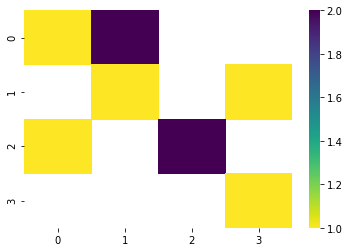

In [60]:
import seaborn as sns

sns.heatmap(pd.DataFrame(d), cmap='viridis_r')

## `namedtuple`

Namedtuples implement immutable simple data types also called POD or plain old data types:

In [61]:
from collections import namedtuple

Point = namedtuple('Point', ['x', 'y', 'z'])
p1 = Point(z=2, x=1, y=0)

for c in p1:
    print(c)
    
print(p1.x, p1.y, p1.z)

1
0
2
1 0 2


# Misc topics we could not include

- coroutines, `async`, `await`, more in [PEP-492](https://www.python.org/dev/peps/pep-0492/)

# See also

Decorator overview with some advanced techniques: https://www.youtube.com/watch?v=9oyr0mocZTg

A very deep dive into decorators: https://www.youtube.com/watch?v=7jGtDGxgwEY